# Solving a mincost SAT problem using QAOA

We want to solve our configuration example from the Poster.

The system can be described by the following boolean formulae:
$
(x_1 \vee x_2) \wedge (x_3 \oplus x_4) \wedge (x_5 \implies x_6)
\iff
(x_1 \vee x_2) \wedge (\neg x_3 \vee \neg x_4) \wedge (x_3 \vee x_4) \wedge (\neg x_5 \vee x_6)
$

The right hand side is in conjunctive normal form (CNF).

Furthermore, there is an implementation cost associated with each feature, as shown in the table below.

| Feature | Cost $c_i$ |
| --- | --- |
| $x_1$ | 30 |
| $x_2$ | 20 |
| $x_3$ | 25 |
| $x_4$ | 50 |
| $x_5$ | 10 |
| $x_6$ | 10 |

## Creating a cost function satisfying features

[Glover](https://arxiv.org/abs/1811.11538) described quadratic penalties for the 2-SAT problem by treating inputs as $0/1$ values, forming a traditional constraint and then deriving a quadratic penalty. We summarize their work here:

| Clause Type | Example | Constraint | Penalty |
|---|---|---|---|
| No Negations  | $$(x_i \vee x_j)$$               | $$x_i + x_j = 1$$            | $$(1 - x_i - x_j + x_i x_j)$$
| One Negation  | $$(x_i \vee \lnot{}x_j)$$        | $$x_i + (1-x_j) \geq 1$$     | $$(x_j - x_i x_j)$$
| Two Negations | $$(\lnot{}x_i \vee \lnot{}x_j)$$ | $$(1-x_i) + (1-x_j) \geq 1$$ | $$(x_i x_j)$$


Using these penalties we can transform our example into a QUBO model.

$$
min~y(x) = 2-x_1-x_2-x_3-x_4+x_5+x_1*x_2+2*x_3*x_4-x_5*x_6
$$

$y(x)$ is the integer of unsatisfied clauses. In other words, $y=0$ indicates that all clauses are satisfied, which is desired for this problem.

## Creating a cost function for feature costs

For the feature costs, we can formulate a sum that adds a features cost if it is in the input vector x.
$$
k(x) = \sum_{x}^{} c_i x_i
$$


## Combining the functions
In our example, we want to find a valid configuration with the minimum cost, so we sum the two previous functions and add a penalty factor $\alpha$ to be able to change the influence of our SAT constraints.

$$
min~f(x) = k(x) + \alpha y(x)
$$

We assume $\alpha \gg 0$, the exact value probably depends on the value of $k(x)$.

## Forming Hamiltonians
We got our QUBO cost function defined. We now need to transform the Binary input space $x_i \in \{0,1\}$ to the Ising Spin model of $s_i \in \{-1, 1\}$. 

Replace $x_i$ with $S_i = 2x_i-1$ meaning $x_i = \frac{1 - S_i}{2}$ (Note that switching the sign changes the eigenvectors)

### Cost Hamiltonian for the SAT part
Before applying it to the entire function, let's first consider only $min~y(x)$.

Ising Form:
$$
min~y(s) = 2-\frac{1-s_1}{2}-\frac{1-s_2}{2}-\frac{1-s_3}{2}-\frac{1-s_4}{2}+\frac{1-s_5}{2}+\frac{1-s_1}{2}*\frac{1-s_2}{2}+2*\frac{1-s_3}{2}*\frac{1-s_4}{2}-\frac{1-s_5}{2}*\frac{1-s_6}{2}
$$
Simplified to (not really needed):
$$ 
min~y(s) = (4 + s_2 + s_1 (1 + s_2) + 2 s_3 s_4 + s_6 - s_5 (1 + s_6))*\frac{1}{4}
$$
Which expands to:
$$
min~y(s) = 1 + s_1\frac{1}{4} + s_2\frac{1}{4} + s_1 s_2\frac{1}{4} + s_3 s_4 \frac{1}{2} - s_5\frac{1}{4} + s_6\frac{1}{4} - s_5 s_6 \frac{1}{4}
$$
And leaves us with a cost hamiltonian $H_C$ with Pauli-Z-Gates $\sigma^z_i$ and an Identity $I$ on the global phase(?):
$$
H_C = 1*I + \sigma^z_1\frac{1}{4} + \sigma^z_2\frac{1}{4} + \sigma^z_1 \sigma^z_2\frac{1}{4} + \sigma^z_3 \sigma^z_4 \frac{1}{2} - \sigma^z_5\frac{1}{4} + \sigma^z_6\frac{1}{4} - \sigma^z_5 \sigma^z_6 \frac{1}{4}
$$

### Cost Hamiltonian for the feature costs
We can expand the feature costs in our example according to the table above.
$$
min~k(x) = \sum_{x}^{} c_i x_i \\
= 30*x_1 + 20*x_2 + 25*x_3 + 50*x_4 + 30*x_5 + 10*x_6
$$
Which we then again transform into Ising form.

$$
min~k(s) = 15*(1-s_1) + 10*(1-s_2)+ 12.5*(1-s_3) + 25*(1-s_4) + 15*(1-s_5) + 5*(1-s_6) \\
min~k(s) = 82.5 - 15 s_1 - 10 s_2 - 12.5 s_3 - 25 s_4 - 15 s_5 - 5 s_6
$$

Which leaves us with our cost Hamiltonian $H_{Ck}$
$$
H_{Ck} = 82.5 I - 15 \sigma^z_1 - 10 \sigma^z_2 - 12.5 \sigma^z_3 - 25 \sigma^z_4 - 15 \sigma^z_5 - 5 \sigma^z_6
$$

### Combining Hamiltonians

All that's left to do is choosing a suitable $\alpha$ and combining the functions.

We choose $\alpha = 1000$ as a first guess ($82.5 * 10$ rounded up).

$$
H_{Ctot} = H_{Ck} + \alpha ~ H_C
$$

$$
H_{Ctot} = 82.5 I - 15 \sigma^z_1 - 10 \sigma^z_2 - 12.5 \sigma^z_3 - 25 \sigma^z_4 - 15 \sigma^z_5 - 5 \sigma^z_6  + 1000*I + \sigma^z_1 250 + \sigma^z_2 250 + \sigma^z_1 \sigma^z_2 250 + \sigma^z_3 \sigma^z_4 500 - \sigma^z_5 250 + \sigma^z_6 250 - \sigma^z_5 \sigma^z_6 250
$$

simplified to

$$
H_{Ctot} = 1082.5 I + 250 \sigma^z_1 \sigma^z_2 + 235 \sigma^z_1 + 240 \sigma^z_2 + 500 \sigma^z_3 \sigma^z_4 - 12.5 \sigma^z_3 - 25 \sigma^z_4 - 250 \sigma^z_5 \sigma^z_6 - 265 \sigma^z_5 + 245 \sigma^z_6
$$

In [1]:
# Imports
from qiskit import Aer, transpile, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

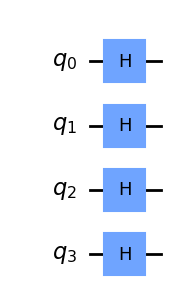

In [2]:
# Uniform Superposition Initialization
def superposition_circuit(nqubits: int) -> QuantumCircuit:
    qc_0 = QuantumCircuit(nqubits)
    for i in range(0, nqubits):
        qc_0.h(i)
    return qc_0

superposition_circuit(4).draw(output="mpl")

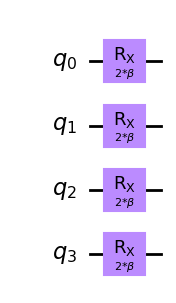

In [3]:
# Mixer Hamiltonian
def mixer_circuit(nqubits: int) -> QuantumCircuit:
    beta = Parameter("$\\beta$")
    qc_mix = QuantumCircuit(nqubits)
    for i in range(0, nqubits):
        qc_mix.rx(2 * beta, i)
    return qc_mix, beta
    
example_qc_mixer, _ = mixer_circuit(4)
example_qc_mixer.draw(output="mpl")

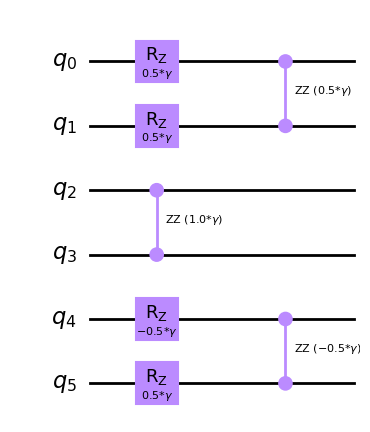

In [4]:
# Cost Hamiltonian
def problem_circuit(hamiltonian: [], nqubits: int) -> QuantumCircuit:
    gamma = Parameter("$\\gamma$")
    qc_p = QuantumCircuit(nqubits)
    
    for term in hamiltonian:
        factor, q1, q2 = term
        
        # case single qubit term
        if q2 is None:
            if q1 is not None:
                qc_p.rz(2 * factor * gamma, q1-1)
            
        # case two qubit term
        else:
            qc_p.rzz(2 * factor * gamma, q1-1, q2-1)
        
        # barrier to delimit terms
        #qc_p.barrier()
    
    return qc_p, gamma
    
# Hamiltonians may be described as a list of tuples containing a factor and up to two qubits 
# hamiltonian = [(factor, q1, q2)]
hamiltonian = [
    (1, None, None),
    (0.25, 1, None),
    (0.25, 2, None),
    (-0.25, 5, None),
    (0.25, 6, None),
    (0.25, 1, 2),
    (0.5, 3, 4),
    (-0.25, 5, 6),
]
example_qc_problem, _ = problem_circuit(hamiltonian, 6)
example_qc_problem.draw(output="mpl")

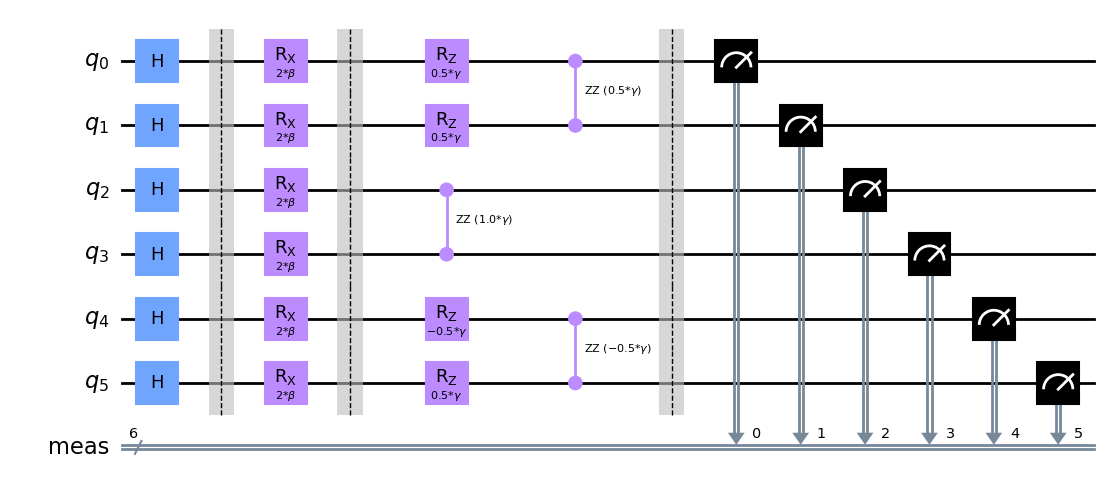

In [5]:
# QAOA Circuit
def qaoa_circuit(hamiltonian, nqubits, nlayers) -> QuantumCircuit:
    qc = superposition_circuit(nqubits)
    
    qg_mixer, beta = mixer_circuit(nqubits)
#     qg_mixer.name = "Mixer"
    qg_problem, gamma = problem_circuit(hamiltonian, nqubits)
#     qg_problem.name = "Problem"
    
    for l in range(nlayers):
        qc.barrier()
        qc = qc.compose(qg_mixer)
        qc.barrier()
        qc = qc.compose(qg_problem)
        
    qc.measure_all()
    return qc, beta, gamma


example_qaoa_circuit, _, _ = qaoa_circuit(hamiltonian, 6, 1)
example_qaoa_circuit.draw(output="mpl")

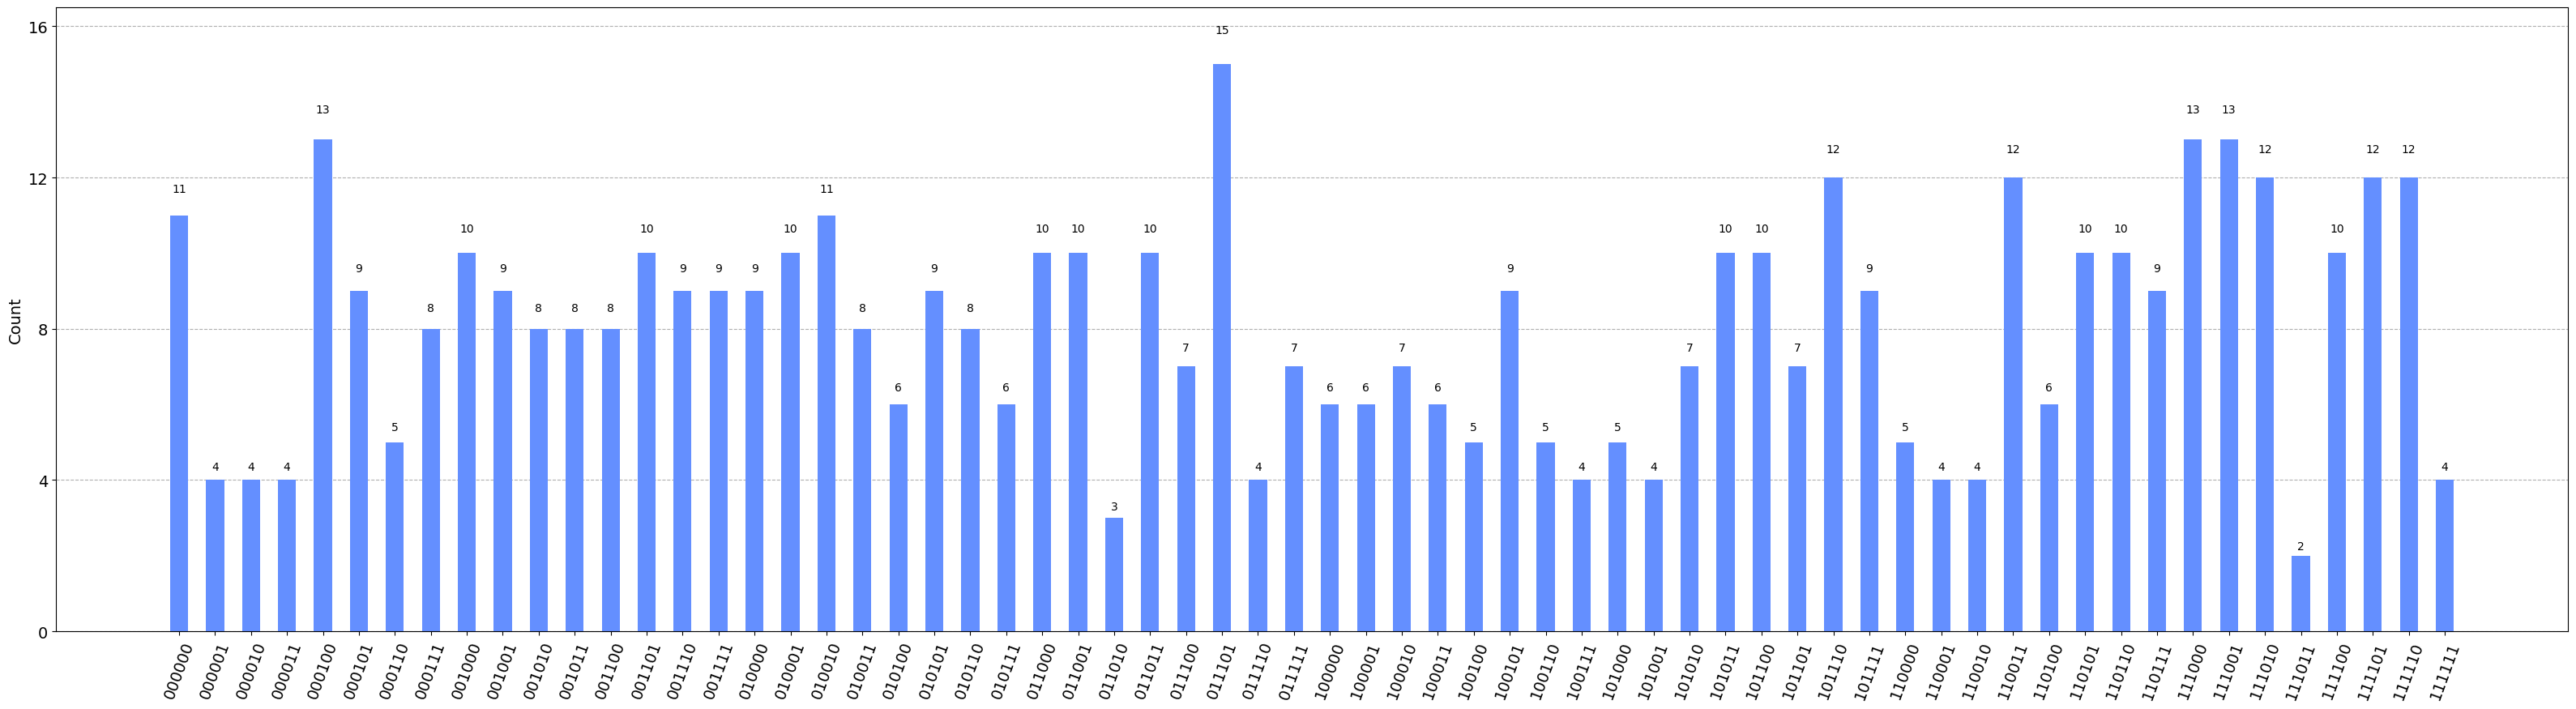

In [6]:
# QAOA Procedure
def quantum(hamiltonian, nqubits, layers, beta_val, gamma_val, shots=512):
    qc, beta, gamma = qaoa_circuit(hamiltonian, nqubits, layers)
        
    # Set parameters for qc
    qc = qc.bind_parameters({
        beta: beta_val,
        gamma: gamma_val
    })

    # run and measure qc
    qasm_sim = Aer.get_backend('qasm_simulator')
    transpiled_qaoa = transpile(qc, qasm_sim)
    results = qasm_sim.run(transpiled_qaoa, shots=shots).result()
    counts = results.get_counts()

    return plot_histogram(counts, figsize=(40, 10))
    plt.show()
        
quantum(hamiltonian, 6, 1, 1, 1)

[1, 1, 1, -1, -1, 1] 2080.0
[-1, 1, 1, -1, 1, 1] 80.0
[1, 1, 1, -1, -1, -1] 1090.0
[1, -1, 1, 1, -1, -1] 1060.0
[1, -1, -1, 1, 1, 1] 45.0
[1, -1, -1, 1, 1, 1] 45.0
[-1, -1, 1, -1, -1, -1] 140.0
[-1, 1, 1, -1, -1, 1] 1110.0
[1, 1, -1, -1, 1, 1] 2075.0
[1, 1, 1, 1, -1, 1] 3030.0
[-1, -1, 1, -1, 1, 1] 100.0
[-1, -1, 1, 1, 1, -1] 1060.0
[-1, -1, -1, -1, -1, 1] 2155.0
[-1, -1, -1, 1, -1, 1] 1105.0
[-1, -1, -1, 1, 1, 1] 75.0
[1, 1, -1, 1, 1, 1] 1025.0
[1, 1, 1, 1, 1, 1] 2000.0
[-1, 1, -1, -1, -1, -1] 1145.0
[-1, 1, -1, 1, -1, 1] 1085.0
[-1, -1, -1, 1, 1, 1] 75.0
[-1, 1, -1, 1, -1, -1] 95.0
[-1, 1, -1, 1, 1, 1] 55.0
[-1, 1, -1, 1, -1, 1] 1085.0
[-1, -1, 1, 1, -1, 1] 2080.0
[1, -1, -1, 1, 1, 1] 45.0
[-1, -1, 1, 1, 1, 1] 1050.0
[1, -1, -1, 1, 1, 1] 45.0
[-1, 1, 1, 1, 1, 1] 1030.0
     fun: 1030.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 28
  status: 1
 success: True
       x: array([2.44632361, 0.77470952])


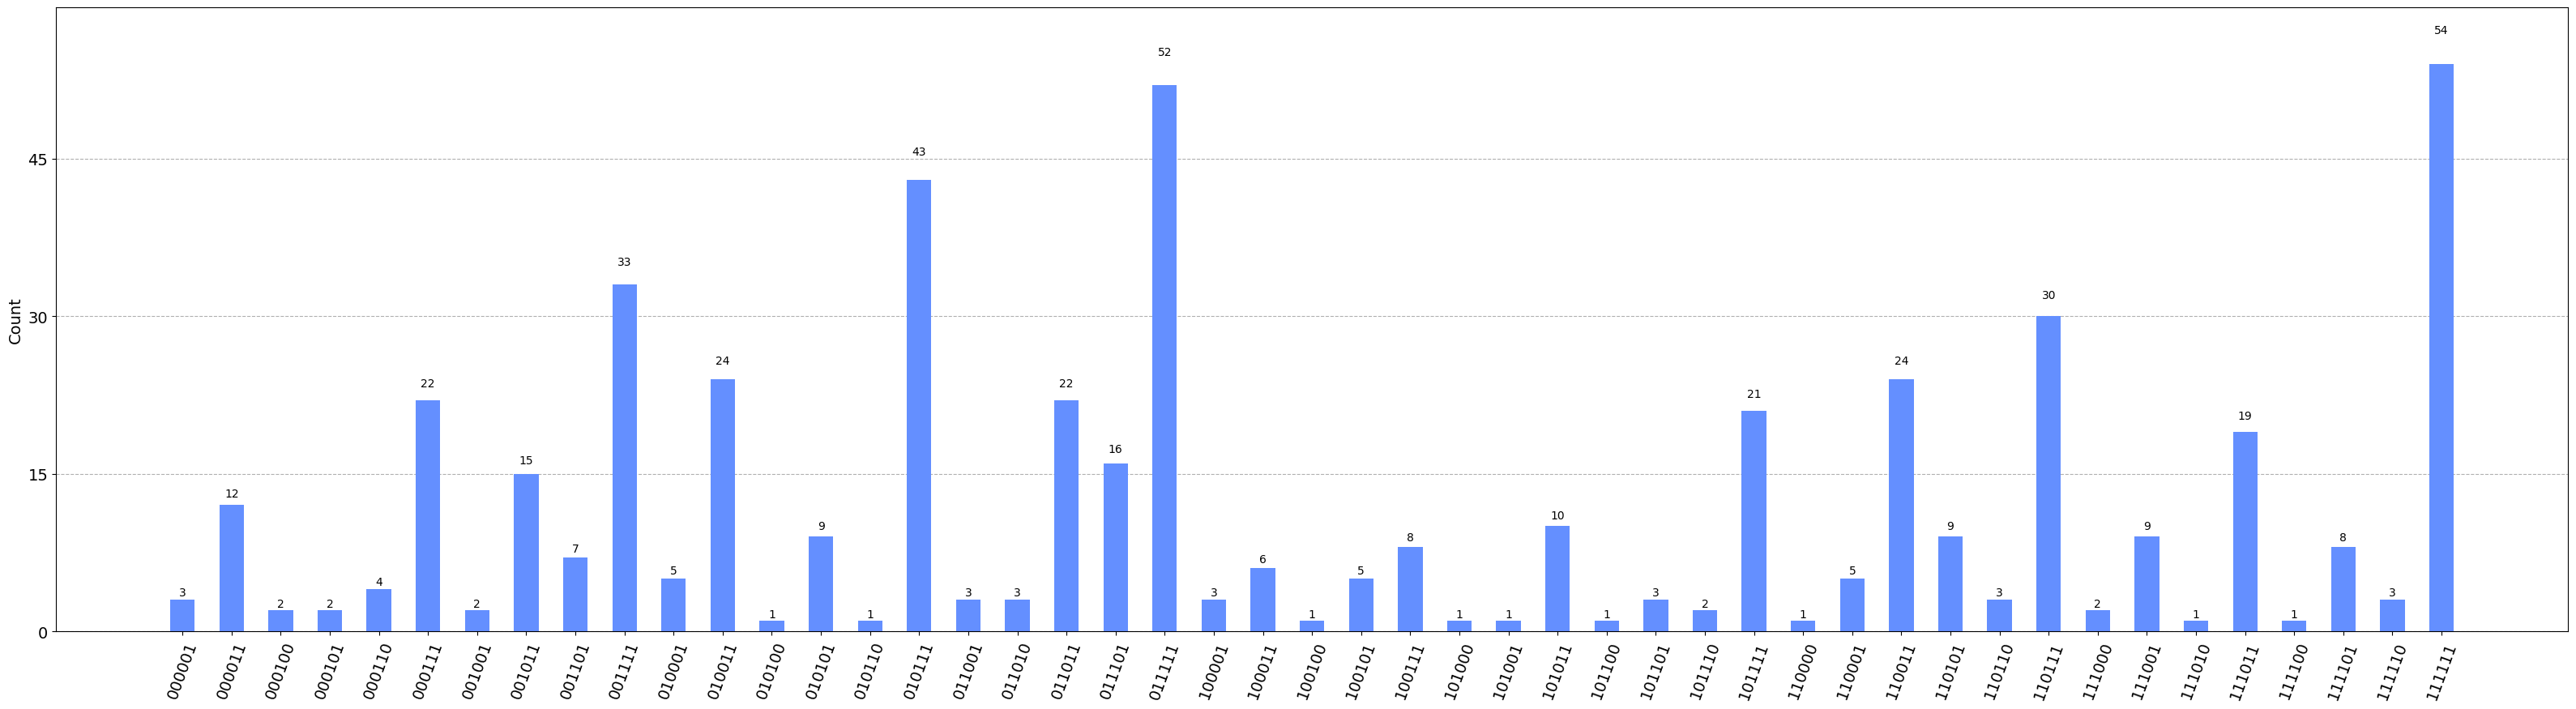

In [25]:
# QAOA Using Optimizer
from scipy.optimize import minimize

def compute_config_cost(configuration: str) -> float:
    feature_costs = [30, 20, 25, 50, 10, 10]
    
    cost = 0
    # assume single shot
    config = list(configurations.keys())[0]
    for i, feat in enumerate(config):
        if feat == '1':
            cost += feature_cost[i]
            
    return cost

def compute_hamiltonian_energy(hamiltonian, counts):
    def compute_config_energy(config: str):
        energy = 0
        for term in hamiltonian:
            factor, q1, q2 = term

            if q1 is None:
                energy += factor
                continue

            if q2 is None:
                energy += factor * config[q1-1]
            else:
                energy += factor * config[q1-1] * config[q2-1]

        print(config, energy)
        return energy
    
    # take the config that was measured most often
    config_str = max(counts, key=counts.get) 
    # convert the 0/1 feature string to ising integers
    config = [-1 if s == "0" else 1 for s in config_str]
    return compute_config_energy(config)
    


def get_expectation(hamiltonian, nqubits, nlayers, shots=128):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        qc, beta, gamma = qaoa_circuit(hamiltonian, nqubits, nlayers)
        
        # Set parameters for qc
        qc = qc.bind_parameters({
            beta: theta[0],
            gamma: theta[1]
        })
        
        counts = backend.run(qc, nshots=shots).result().get_counts()
        return compute_hamiltonian_energy(hamiltonian, counts)
    
    return execute_circ

# inputs
# hamiltonian = [(factor, q1, q2)]
feetcost_hamiltonian = [
    (1082.5, None, None),
    (250,    1, 2),
    (235,    1, None),
    (240,    2, None),
    (500,    3, 4),
    (-12.5,  3, None),
    (-25,    4, None),
    (-250,   5, 6),
    (-265,   5, None),
    (245,    6, None)
]
layers = 10 # more layers = higher approximation rate but more quantum errors when running on real qpu
nfeatures = 6


expectation = get_expectation(feetcost_hamiltonian, nfeatures, layers, 128)
res = minimize(expectation, [1, 1], method='COBYLA')

print(res)

# output 
quantum(feetcost_hamiltonian, nfeatures, layers, res.x[0], res.x[1])